In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm


In [3]:

if torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

mps


In [4]:
path = "images/pexels-bdmphoto-3250752.jpg"
im = Image.open(path)
im_tensor_cpu = to_tensor(im).to(device="cpu")
im_tensor_mps =to_tensor(im).to(device="mps") 
print(f"inital tensor size : {im_tensor_cpu.shape}")


max_dim = 250
_, H, W = im_tensor_mps.shape
scale_factor = max_dim / max(H, W)

new_H = int(H * scale_factor)
new_W = int(W * scale_factor)
im_resized = resize(im_tensor_mps.unsqueeze(0), size=[new_H, new_W], antialias=True).squeeze(0)

print(f"rescaled tensor size : {im_resized.shape}")

inital tensor size : torch.Size([3, 4000, 6000])
rescaled tensor size : torch.Size([3, 166, 250])


In [5]:
min_dim = 25            # dimension mini au coarse scale
N = 0
current_H, current_W = new_H, new_W
r = 4 / 3               # scaling factor (environ 1.333)

# Calculer N tel que le coarse scale soit >= min_dim
while current_H >= min_dim and current_W >= min_dim:
    N += 1
    current_H = int(current_H / r)
    current_W = int(current_W / r)
N

7

In [6]:
scales = [im_resized.unsqueeze(0)]    # niveau 0 = fine

for i in range(1, N):
    prev = scales[-1]
    _, _, h, w = prev.shape
    new_h = max(int(h / r), 1)
    new_w = max(int(w / r), 1)
    down = resize(prev, size=[new_h, new_w], antialias=True)
    scales.append(down)


Number of scales N = 7
Scaling factor r = 1.333
Scale 0 : torch.Size([1, 3, 166, 250])


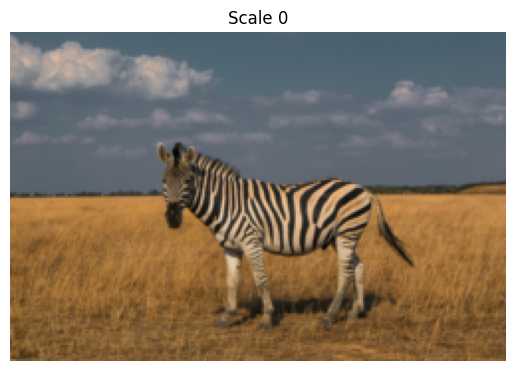

Scale 1 : torch.Size([1, 3, 124, 187])


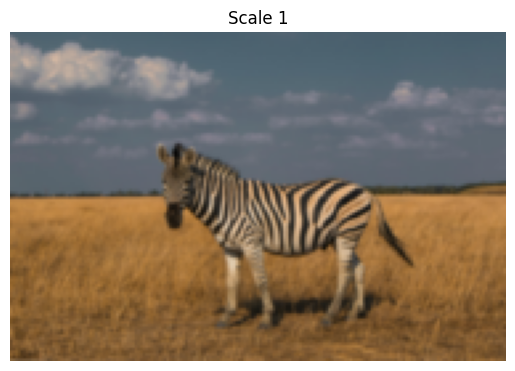

Scale 2 : torch.Size([1, 3, 93, 140])


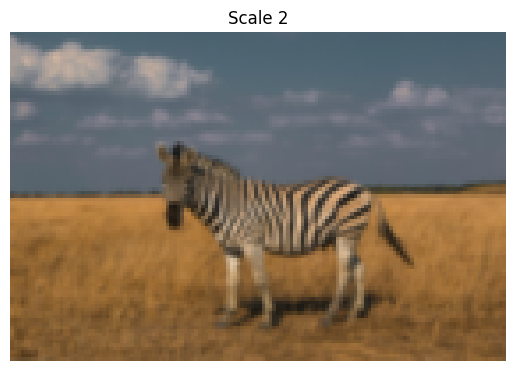

Scale 3 : torch.Size([1, 3, 69, 105])


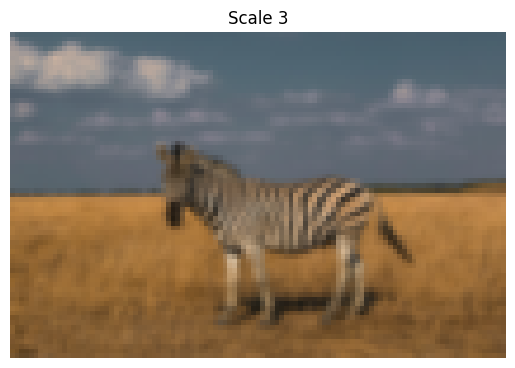

Scale 4 : torch.Size([1, 3, 51, 78])


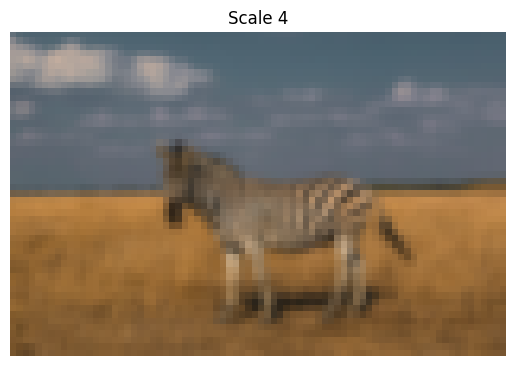

Scale 5 : torch.Size([1, 3, 38, 58])


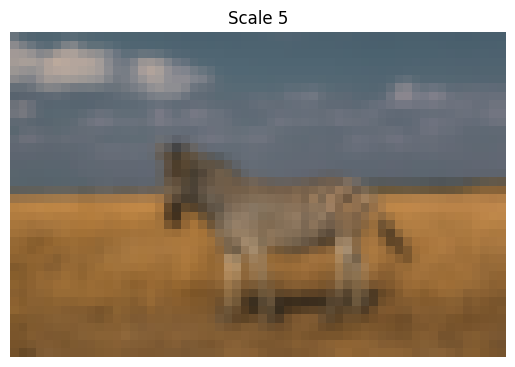

Scale 6 : torch.Size([1, 3, 28, 43])


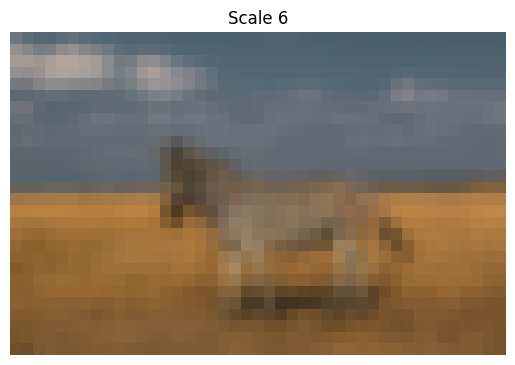

In [7]:
print(f"Number of scales N = {N}")
print(f"Scaling factor r = {r:.3f}")
for i, im_scale in enumerate(scales):
    print(f"Scale {i} : {im_scale.shape}")
    plt.imshow(to_pil_image(im_scale.squeeze().cpu()))
    plt.axis('off')
    plt.title(f"Scale {i}")
    plt.show()


In [8]:
class Generator(nn.Module):
    
    def __init__(self,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.n_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            # Last conv layer outputs 3 channels (RGB), no batchnorm or activation
            nn.Conv2d(self.n_hidden, 3, 3, padding=1),
            nn.Tanh()
        )
        
    def forward(self,input):
        return self.main(input)

In [9]:
class Discriminator(nn.Module):
    def __init__(self,n_hidden):
        
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(3, self.n_hidden, kernel_size=3, padding=1),  
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, 1, 3, padding=1)  
        )
    
    def forward(self,input):
        return self.main(input)

In [10]:
input_size_visu = (3, 1024, 1024)
netG_visu = Generator(n_hidden=32).to("cpu")
torchsummary.summary(netG_visu, input_size=input_size_visu,device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 3, 1024, 1024]             867
             Tanh-14        [-1, 3, 102

In [11]:
netD_visu = Discriminator(n_hidden=32).to("cpu")
torchsummary.summary(netD_visu, input_size=input_size_visu,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 1, 1024, 1024]             289
Total params: 29,185
Trainable params: 

+ Générations des generateurs/discriminateurs

In [23]:
hidden_lowest_dim = 32
Genarators = []
Discriminators = []

for i in range(N):
    r = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(r//4)).to(device))
    Discriminators.append(Discriminator(hidden_lowest_dim * 2**(r//4)).to(device))
    
Genarators.reverse()
Discriminators.reverse()

for gen in Genarators : 
     print(gen.n_hidden)
for dis in Discriminators:
     print(dis.n_hidden)


32
32
32
64
64
64
64
32
32
32
64
64
64
64


+ Boucle d'entrainement 

In [24]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


for G in Genarators:
    G.apply(weights_init)
for D in Discriminators:
    D.apply(weights_init)

it scale 6:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 6 | it 0]  Lips ≈ 0.16


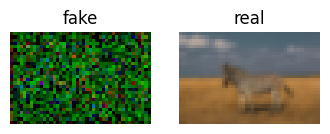

it scale 6:  10%|█         | 200/2000 [00:20<03:09,  9.49it/s]

[scale 6 | it 200]  Lips ≈ 1.13


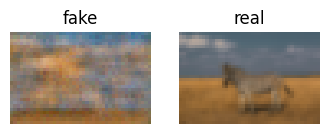

it scale 6:  20%|█▉        | 399/2000 [06:52<06:09,  4.33it/s]   

[scale 6 | it 400]  Lips ≈ 1.18


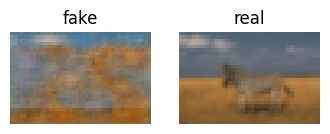

it scale 6:  30%|██▉       | 599/2000 [39:07<2:48:39,  7.22s/it]   

[scale 6 | it 600]  Lips ≈ 1.43


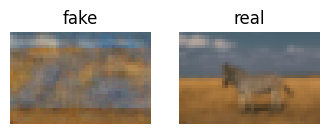

it scale 6:  40%|████      | 800/2000 [39:27<02:00,  9.97it/s]  

[scale 6 | it 800]  Lips ≈ 1.20


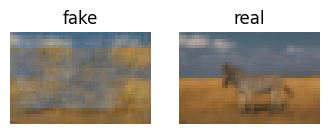

it scale 6:  50%|█████     | 1000/2000 [39:47<01:37, 10.22it/s]

[scale 6 | it 1000]  Lips ≈ 1.22


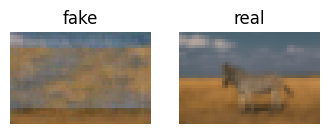

it scale 6:  60%|█████▉    | 1199/2000 [40:07<01:18, 10.17it/s]

[scale 6 | it 1200]  Lips ≈ 1.36


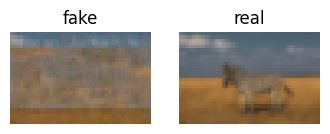

it scale 6:  70%|███████   | 1400/2000 [40:27<01:00,  9.86it/s]

[scale 6 | it 1400]  Lips ≈ 1.12


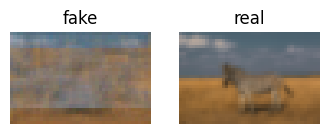

it scale 6:  80%|████████  | 1600/2000 [40:47<00:39, 10.15it/s]

[scale 6 | it 1600]  Lips ≈ 1.23


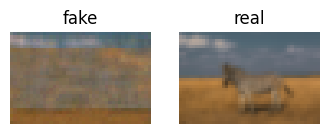

it scale 6:  90%|█████████ | 1800/2000 [41:07<00:19, 10.19it/s]

[scale 6 | it 1800]  Lips ≈ 1.31


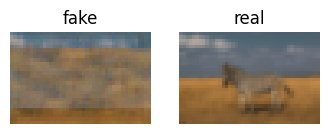

[init] copied weights from scale 6 → 5


it scale 5:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 5 | it 0]  Lips ≈ 1.28


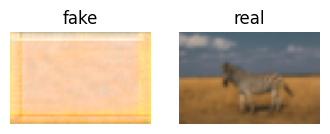

it scale 5:  10%|█         | 200/2000 [00:19<02:58, 10.07it/s]

[scale 5 | it 200]  Lips ≈ 1.12


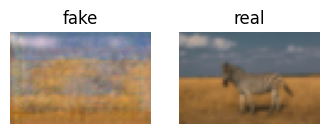

it scale 5:  20%|█▉        | 399/2000 [00:39<02:41,  9.92it/s]

[scale 5 | it 400]  Lips ≈ 1.07


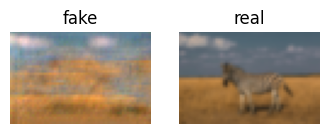

it scale 5:  30%|███       | 600/2000 [01:00<02:22,  9.81it/s]

[scale 5 | it 600]  Lips ≈ 1.38


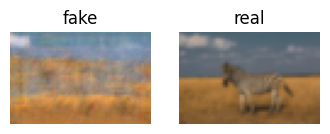

it scale 5:  40%|████      | 800/2000 [01:20<01:59, 10.05it/s]

[scale 5 | it 800]  Lips ≈ 1.05


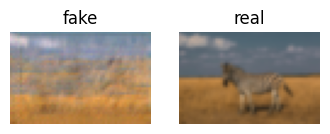

it scale 5:  50%|█████     | 1000/2000 [01:41<01:42,  9.71it/s]

[scale 5 | it 1000]  Lips ≈ 1.38


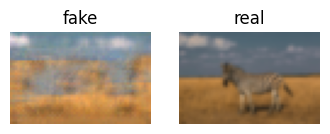

it scale 5:  60%|██████    | 1200/2000 [02:02<01:21,  9.78it/s]

[scale 5 | it 1200]  Lips ≈ 1.28


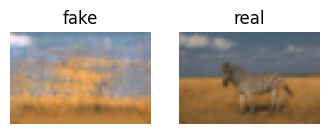

it scale 5:  70%|███████   | 1400/2000 [02:22<00:59, 10.06it/s]

[scale 5 | it 1400]  Lips ≈ 1.67


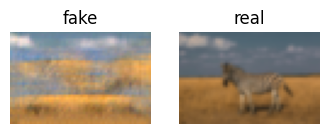

it scale 5:  80%|████████  | 1600/2000 [02:42<00:40,  9.79it/s]

[scale 5 | it 1600]  Lips ≈ 1.35


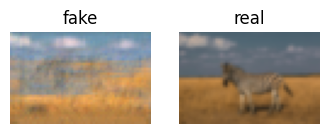

it scale 5:  90%|█████████ | 1800/2000 [03:03<00:20,  9.78it/s]

[scale 5 | it 1800]  Lips ≈ 1.80


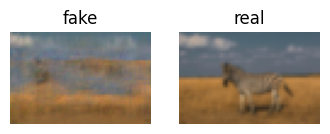

[init] copied weights from scale 5 → 4


it scale 4:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 4 | it 0]  Lips ≈ 1.34


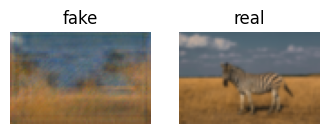

it scale 4:  10%|█         | 200/2000 [00:24<03:35,  8.34it/s]

[scale 4 | it 200]  Lips ≈ 1.32


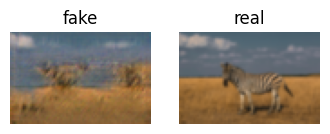

it scale 4:  20%|██        | 400/2000 [00:49<03:13,  8.25it/s]

[scale 4 | it 400]  Lips ≈ 1.78


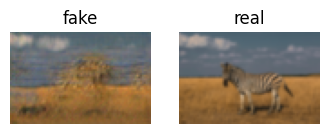

it scale 4:  30%|███       | 600/2000 [01:14<03:05,  7.54it/s]

[scale 4 | it 600]  Lips ≈ 1.27


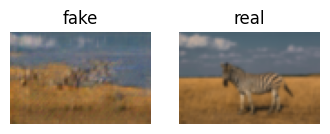

it scale 4:  40%|████      | 800/2000 [01:43<03:03,  6.53it/s]

[scale 4 | it 800]  Lips ≈ 1.15


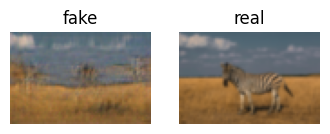

it scale 4:  50%|█████     | 1000/2000 [02:14<02:42,  6.17it/s]

[scale 4 | it 1000]  Lips ≈ 1.06


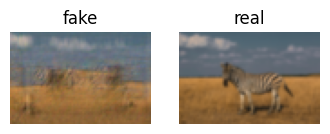

it scale 4:  60%|██████    | 1200/2000 [02:47<02:12,  6.04it/s]

[scale 4 | it 1200]  Lips ≈ 1.12


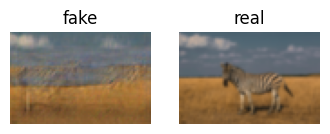

it scale 4:  70%|███████   | 1400/2000 [03:21<01:40,  5.96it/s]

[scale 4 | it 1400]  Lips ≈ 1.28


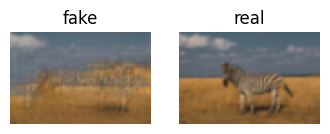

it scale 4:  80%|████████  | 1600/2000 [03:54<01:07,  5.94it/s]

[scale 4 | it 1600]  Lips ≈ 1.46


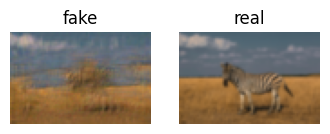

it scale 4:  90%|█████████ | 1800/2000 [04:27<00:33,  5.99it/s]

[scale 4 | it 1800]  Lips ≈ 1.31


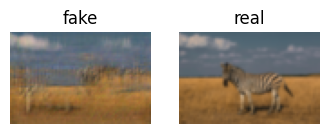

[init] copied weights from scale 4 → 3


it scale 3:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 3 | it 0]  Lips ≈ 1.13


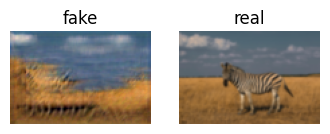

it scale 3:  10%|█         | 200/2000 [00:47<07:08,  4.20it/s]

[scale 3 | it 200]  Lips ≈ 1.61


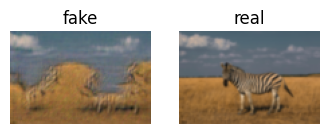

it scale 3:  20%|██        | 400/2000 [01:34<06:20,  4.20it/s]

[scale 3 | it 400]  Lips ≈ 1.53


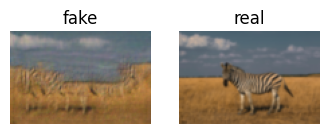

it scale 3:  30%|███       | 600/2000 [02:22<05:33,  4.20it/s]

[scale 3 | it 600]  Lips ≈ 1.22


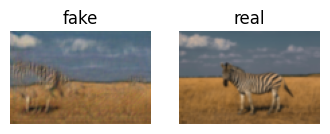

it scale 3:  40%|████      | 800/2000 [03:10<04:48,  4.16it/s]

[scale 3 | it 800]  Lips ≈ 1.26


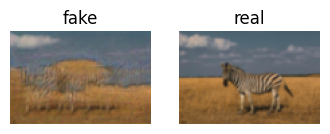

it scale 3:  50%|█████     | 1000/2000 [03:58<03:59,  4.17it/s]

[scale 3 | it 1000]  Lips ≈ 1.06


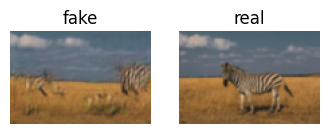

it scale 3:  60%|██████    | 1200/2000 [04:46<03:12,  4.15it/s]

[scale 3 | it 1200]  Lips ≈ 1.14


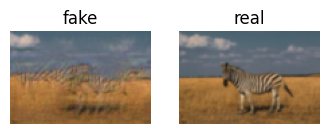

it scale 3:  70%|███████   | 1400/2000 [05:34<02:24,  4.16it/s]

[scale 3 | it 1400]  Lips ≈ 1.27


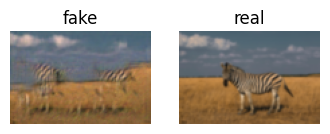

it scale 3:  80%|████████  | 1600/2000 [06:23<01:36,  4.13it/s]

[scale 3 | it 1600]  Lips ≈ 1.39


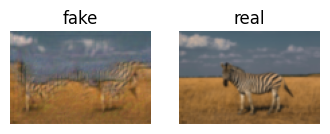

it scale 3:  90%|█████████ | 1800/2000 [07:11<00:48,  4.13it/s]

[scale 3 | it 1800]  Lips ≈ 1.42


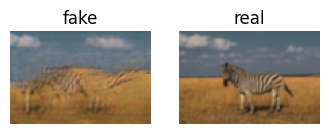

it scale 2:   0%|          | 0/2000 [00:00<?, ?it/s]           

[scale 2 | it 0]  Lips ≈ 0.03


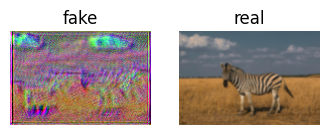

it scale 2:  10%|█         | 200/2000 [00:38<05:46,  5.20it/s]

[scale 2 | it 200]  Lips ≈ 1.06


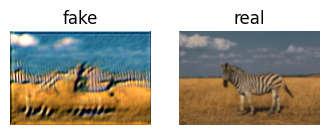

it scale 2:  20%|██        | 400/2000 [01:17<05:13,  5.10it/s]

[scale 2 | it 400]  Lips ≈ 1.17


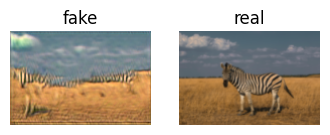

it scale 2:  30%|███       | 600/2000 [01:56<04:30,  5.17it/s]

[scale 2 | it 600]  Lips ≈ 1.36


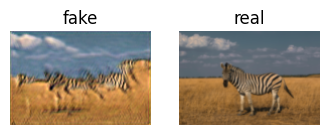

it scale 2:  40%|████      | 800/2000 [02:34<03:49,  5.22it/s]

[scale 2 | it 800]  Lips ≈ 0.93


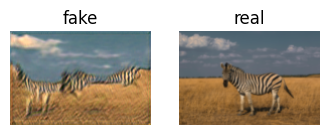

it scale 2:  50%|█████     | 1000/2000 [03:13<03:13,  5.16it/s]

[scale 2 | it 1000]  Lips ≈ 0.83


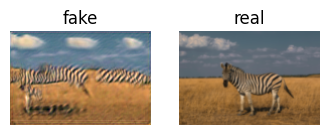

it scale 2:  60%|██████    | 1200/2000 [03:52<02:35,  5.14it/s]

[scale 2 | it 1200]  Lips ≈ 0.98


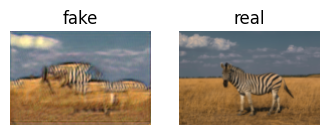

it scale 2:  70%|███████   | 1400/2000 [04:31<01:55,  5.17it/s]

[scale 2 | it 1400]  Lips ≈ 1.24


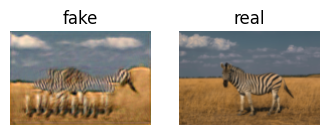

it scale 2:  80%|████████  | 1600/2000 [05:10<01:17,  5.17it/s]

[scale 2 | it 1600]  Lips ≈ 1.43


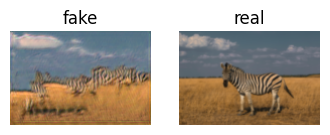

it scale 2:  90%|█████████ | 1800/2000 [05:49<00:38,  5.14it/s]

[scale 2 | it 1800]  Lips ≈ 1.01


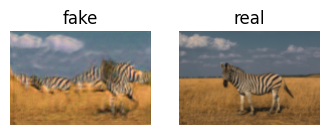

[init] copied weights from scale 2 → 1


it scale 1:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 1 | it 0]  Lips ≈ 1.32


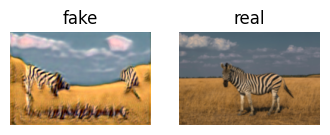

it scale 1:  10%|█         | 200/2000 [01:06<10:05,  2.97it/s]

[scale 1 | it 200]  Lips ≈ 1.06


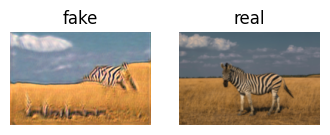

it scale 1:  20%|██        | 400/2000 [02:12<08:51,  3.01it/s]

[scale 1 | it 400]  Lips ≈ 1.61


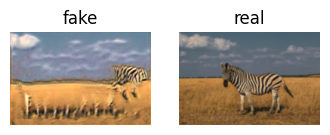

it scale 1:  30%|███       | 600/2000 [03:18<07:43,  3.02it/s]

[scale 1 | it 600]  Lips ≈ 1.62


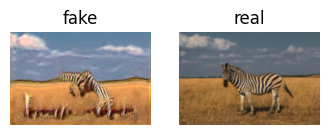

it scale 1:  40%|████      | 800/2000 [04:25<06:38,  3.01it/s]

[scale 1 | it 800]  Lips ≈ 0.99


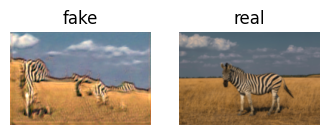

it scale 1:  50%|█████     | 1000/2000 [05:31<05:33,  3.00it/s]

[scale 1 | it 1000]  Lips ≈ 1.51


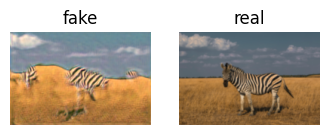

it scale 1:  60%|██████    | 1200/2000 [06:38<04:27,  2.99it/s]

[scale 1 | it 1200]  Lips ≈ 1.32


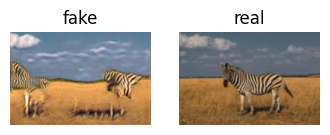

it scale 1:  70%|███████   | 1400/2000 [07:45<03:18,  3.02it/s]

[scale 1 | it 1400]  Lips ≈ 1.15


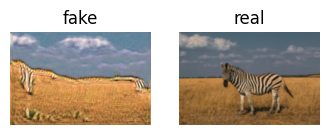

it scale 1:  80%|████████  | 1600/2000 [08:52<02:14,  2.98it/s]

[scale 1 | it 1600]  Lips ≈ 1.24


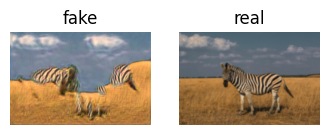

it scale 1:  90%|█████████ | 1800/2000 [09:59<01:07,  2.95it/s]

[scale 1 | it 1800]  Lips ≈ 1.46


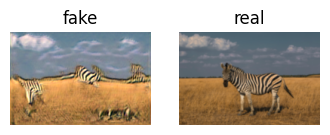

[init] copied weights from scale 1 → 0


it scale 0:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 0 | it 0]  Lips ≈ 1.04


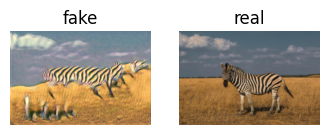

it scale 0:  10%|█         | 200/2000 [02:04<18:23,  1.63it/s]

[scale 0 | it 200]  Lips ≈ 1.44


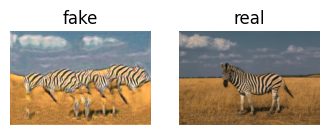

it scale 0:  20%|██        | 400/2000 [04:07<16:27,  1.62it/s]

[scale 0 | it 400]  Lips ≈ 1.45


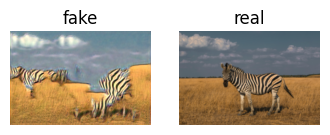

it scale 0:  30%|███       | 600/2000 [58:21<50:53,  2.18s/it]     

[scale 0 | it 600]  Lips ≈ 1.38


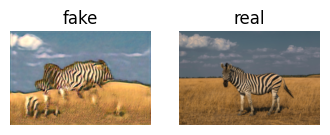

it scale 0:  40%|████      | 800/2000 [1:26:40<10:57,  1.82it/s]     

[scale 0 | it 800]  Lips ≈ 1.23


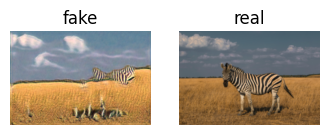

it scale 0:  50%|█████     | 1000/2000 [1:28:32<09:16,  1.80it/s]

[scale 0 | it 1000]  Lips ≈ 1.58


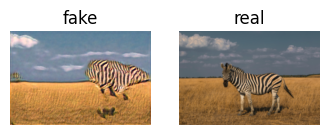

it scale 0:  60%|██████    | 1200/2000 [1:30:24<07:25,  1.80it/s]

[scale 0 | it 1200]  Lips ≈ 1.29


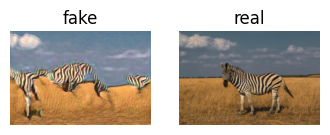

it scale 0:  70%|███████   | 1400/2000 [1:32:15<05:26,  1.84it/s]

[scale 0 | it 1400]  Lips ≈ 1.69


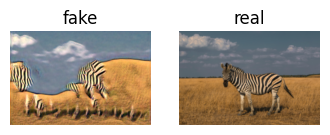

it scale 0:  80%|████████  | 1600/2000 [1:34:05<03:36,  1.84it/s]

[scale 0 | it 1600]  Lips ≈ 1.17


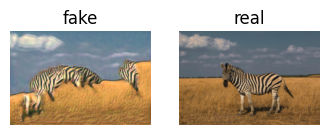

it scale 0:  90%|█████████ | 1800/2000 [1:36:02<02:03,  1.62it/s]

[scale 0 | it 1800]  Lips ≈ 2.08


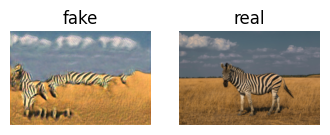

In [25]:
torch.random.manual_seed(0)

# params
lambda_gp    = 10
lr             = 5e-4 # celui du github
betas            = (0.5, 0.999) # pareil
n_Discriminator  = 5 # pif
n_Generator      = 2 # pif
iter_per_scale   = 2_000 # github
alpha_rec      = 10 # gith
beta_sigma   = 0.1 # git
debug          = True
b          = 1                                      # batch size

# reset des optim. #schedulers ???
optimizer_G, optimizer_D = [], []
for i in range(N):
    optimizer_G.append(optim.Adam(Genarators[i].parameters(), lr=lr, betas=betas))
    optimizer_D.append(optim.Adam(Discriminators[i].parameters(), lr=lr, betas=betas))


z_star   = torch.randn_like(scales[-1])               # bruit fixe
sigma_n  = [1.] * N
x_rec    = [None] * N
gen_image = [torch.zeros_like(scales[-1]).to(device)]
       

@torch.no_grad()
def regenerate_prev(k):
    # k : res actuelle
    # retourne une nouvelle image avec le générateur précedent.
    # reprend la dernière image généré et rajoute du bruit puis upsample`
    if k == N-1:
        return torch.zeros_like(scales[k]).to(device)

    low_prev = gen_image[-1]                           
    z_prev   = torch.randn_like(low_prev) * sigma_n[k+1]
    low_fake = Genarators[k+1](z_prev + low_prev) + low_prev

    prev_img = F.interpolate(low_fake,
                             size=scales[k].shape[2:], 
                             mode='bilinear', align_corners=False)
    return prev_img

@torch.no_grad()
def regenerate_prev_full(k):
    """
    Reconstruit un prev_img pour l'échelle k en:
      +  partant d'une image nulle au coarse (N-1),
      + appliquant *tous* les G gelés (N-1 … k+1) avec nouveau bruit,
      +  upsamplant le résultat (k+1) → résolution de k.
    """
    if k == N-1:                                    # échelle coarse → zeros
        return torch.zeros_like(scales[k]).to(device)

    # scale la plus petite
    img = torch.zeros_like(scales[-1]).to(device)   
    z   = torch.randn_like(img) * sigma_n[N-1]
    img = Genarators[N-1](z)                       

    # on remonte le réseau
    for s in range(N-2, k, -1):                     
        img_up = F.interpolate(img,
                               size=scales[s].shape[2:],
                               mode='bilinear', align_corners=False)
        z      = torch.randn_like(img_up) * sigma_n[s]
        img    = Genarators[s](z + img_up) + img_up

    prev_img = F.interpolate(img,
                             size=scales[k].shape[2:],
                             mode='bilinear', align_corners=False)
    return prev_img

def lipconstant(D, x, y):
    
    b = x.size(0)
    if y.size(0) != b:
        raise ValueError("batch sizes differ")

    alpha = torch.rand((b,1,1,1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_(True)

    Di = D(interp).mean()                    # mean sinon ça me donnait des truc abbérant
    gradients = torch.autograd.grad(
        outputs=Di, inputs=interp,
        grad_outputs=torch.ones_like(Di),    
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]

    eps = 1e-12
    gradients_norm = torch.sqrt(gradients.flatten(1).pow(2).sum(1) + eps)
    return gradients_norm.mean()

# trainning toutes les scales
for n in range(N):
    current_res  = N - n - 1          
    Gk = Genarators[current_res].train()
    Dk = Discriminators[current_res].train()
    xk_real = scales[current_res].to(device)
    
    
    if current_res < N-1:                          
        G_prev = Genarators[current_res + 1]
        D_prev = Discriminators[current_res + 1]

        def same_channels(net_a, net_b):
            """return True if first conv out-channels match"""
            for m_a, m_b in zip(net_a.modules(), net_b.modules()):
                if isinstance(m_a, torch.nn.Conv2d):
                    return m_a.out_channels == m_b.out_channels
            return False

        if same_channels(Gk, G_prev):              
            Gk.load_state_dict(G_prev.state_dict(), strict=True)
            Dk.load_state_dict(D_prev.state_dict(), strict=True)
            if debug:
                print(f"[init] copied weights from scale {current_res+1} → {current_res}")

    # NB: from here on, use *Gk* / *Dk*; they already sit in the
    #     Genarators / Discriminators lists, so nothing else changes.
    Gk.train();  Dk.train()
    # (re-attach the optimisers in case parameters were just overwritten)
    opt_G = optimizer_G[current_res]
    opt_D = optimizer_D[current_res]
    

# Calcul ecart type nécessaire pour le bruit.
    if current_res < N-1:
        up_rec = F.interpolate(x_rec[current_res+1],
                               size=xk_real.shape[2:], mode='bilinear', align_corners=False)

        # σ_n = β · RMSE((x_rec[n+1]↑), x_n) / RMSE(0, x_n) # formule trouvé je sais plus ou. 
        num   = F.mse_loss(up_rec, xk_real)             
        denom = F.mse_loss(torch.zeros_like(xk_real), xk_real)
        sigma_n[current_res] = beta_sigma * torch.sqrt(num / denom)   
    else:
        sigma_n[current_res] = torch.tensor(beta_sigma, device=device)

    # itérations par scale
    for it in tqdm(range(iter_per_scale), desc=f"it scale {current_res}", leave=False):

        # prev_img tiré fraichement
        with torch.no_grad():
            prev_img = regenerate_prev_full(current_res)

        # trainning discriminateur
        for _ in range(n_Discriminator):
            opt_D.zero_grad()
            z = torch.randn_like(prev_img) * sigma_n[current_res]
            fake = Gk(z + prev_img) + prev_img

            loss_D = Dk(fake.detach()).mean() - Dk(xk_real).mean()

            # gradient penalty
            alpha = torch.rand(b,1,1,1,device=device)
            interp = (alpha*xk_real + (1-alpha)*fake.detach()).requires_grad_(True)
            grad_out = Dk(interp).mean()
            grad = torch.autograd.grad(grad_out, interp, torch.ones_like(grad_out),
                                       create_graph=True, retain_graph=True, only_inputs=True)[0]
            gp = lambda_gp * ((grad.flatten(1).norm(2,dim=1)-1)**2).mean()
            (loss_D + gp).backward()
            opt_D.step()

        # trainning gen
        for _ in range(n_Generator):
            opt_G.zero_grad()
            z = torch.randn_like(prev_img) * sigma_n[current_res]
            fake = Gk(z + prev_img) + prev_img
            adv_G = -Dk(fake).mean()

            # ----- Reconstruction eq. 5 -----
            if current_res == N-1:                         # coarse
                rec_in = z_star                             # MOD (z_star)
                rec_out = Gk(rec_in)                       # pas de upsample
            else:                                          # n < N
                up_fixed = F.interpolate(x_rec[current_res+1],
                                          size=xk_real.shape[2:], mode='bilinear', align_corners=False)
                rec_in = up_fixed                          # MOD (bruit = 0)
                rec_out = Gk(rec_in) + up_fixed            # MOD

            Lrec = F.mse_loss(rec_out, xk_real)
            (adv_G + alpha_rec * Lrec).backward()
            opt_G.step()

        # logs
        if debug and it % 200 == 0:
            # pas de torch.no_grad() ici : on a besoin du backward dans lipconstant
            lips = lipconstant(Dk, fake.detach(), xk_real)
            print(f"[scale {current_res} | it {it}]  Lips ≈ {lips:.2f}")

            with torch.no_grad():                     # on garde no_grad pour l’affichage
                plt.figure(figsize=(4,2))
                plt.subplot(1,2,1); plt.imshow(to_pil_image(fake[0].cpu().clamp(0,1))); plt.axis('off'); plt.title('fake')
                plt.subplot(1,2,2); plt.imshow(to_pil_image(xk_real[0].cpu()));        plt.axis('off'); plt.title('real')
                plt.show()
    # fige G_k et stocke fake pour l’échelle au-dessus 
    with torch.no_grad():
        gen_image.append(fake.detach())
        if current_res == N-1:
            x_rec[current_res] = Gk(z_star)                              # NEW (bruit fixe)
        else:
            up_rec_k = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            x_rec[current_res] = Gk(up_rec_k) + up_rec_k                 # NEW (bruit 0)
        Gk.eval()
        for p in Gk.parameters(): 
            p.requires_grad_(False)


In [52]:
@torch.no_grad()
def generate_multiscale(start_scale: int = N - 1):
    """
    Génère une pyramide (coarse → fine) à partir des G gelés.

    Paramètres
    ----------
    start_scale : int
        À partir de cette échelle (incluse) on injecte du *nouveau* bruit.
        • 0    → bruit aléatoire partout  (échantillon totalement neuf)
        • N-1 → bruit aléatoire uniquement sur la coarse
    """
    # 1. image nulle à l'échelle coarse (N-1)
    h, w = scales[-1].shape[2:]
    gen_image = [torch.zeros((1, 3, h, w), device=device)]

    # 2. parcours coarse → fine
    for i in range(N):
        k = N - 1 - i                       

        prev = gen_image[-1]
        if prev.shape[2:] != scales[k].shape[2:]:
            prev = F.interpolate(prev, size=scales[k].shape[2:],
                                  mode='bilinear', align_corners=False)

        if k >= start_scale:                
            if k == N - 1:                  
                z = z_star # iciii ? 
            else:
                z = torch.randn_like(prev)*sigma_n[k]
        else:                               # bruit *figé* (reconstruction)
            z = torch.zeros_like(prev) *sigma_n[k]

        x_k = Genarators[k](z + prev) + prev
        gen_image.append(x_k)

    return gen_image[1:]    # renvoie la pyramide [coarse,…,fine]


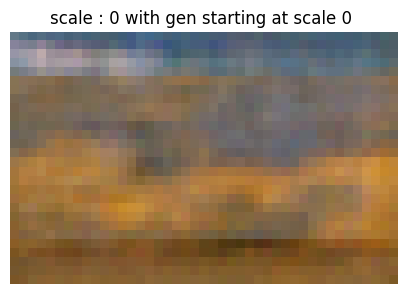

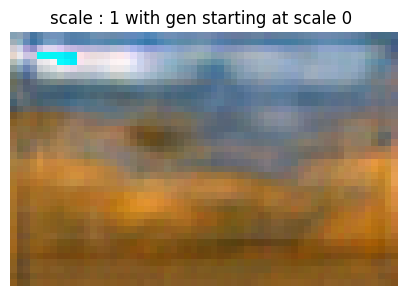

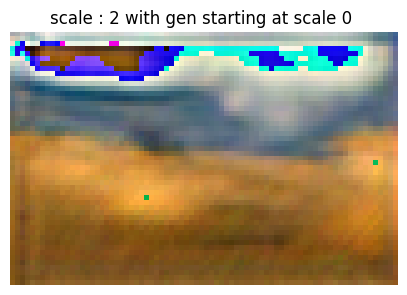

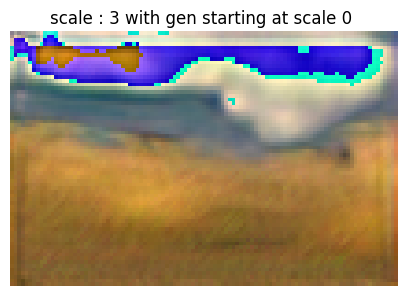

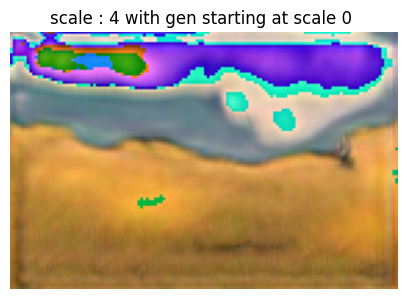

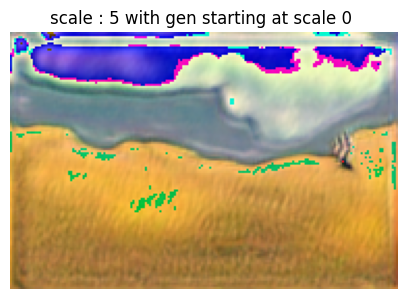

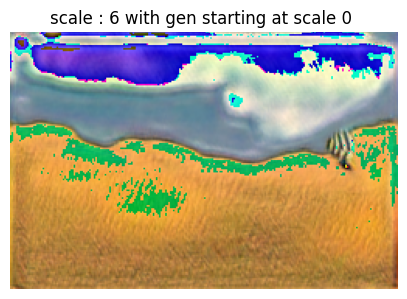

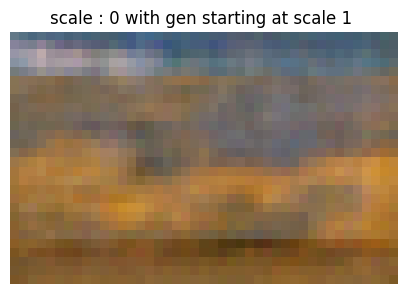

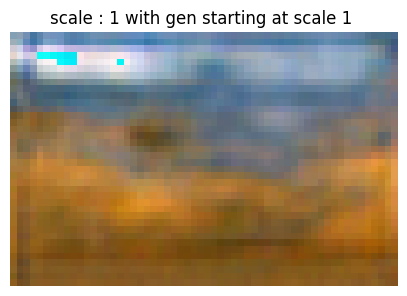

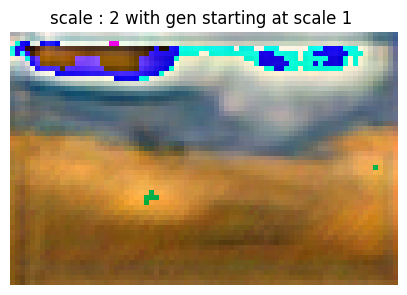

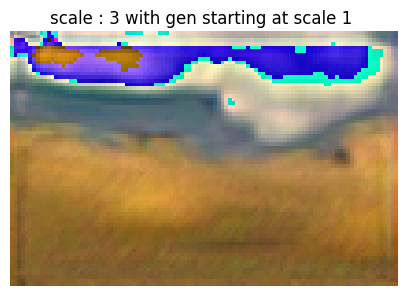

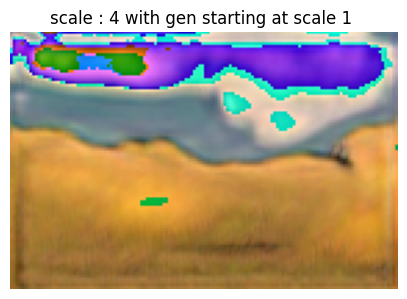

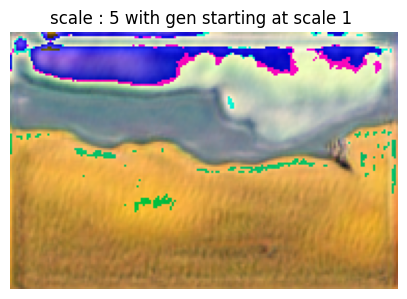

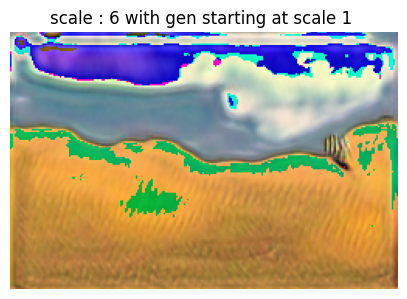

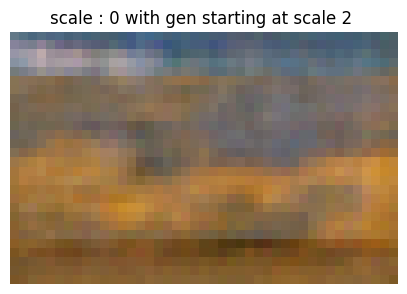

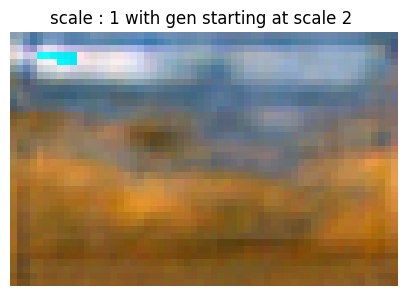

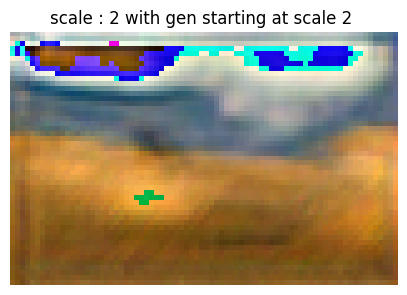

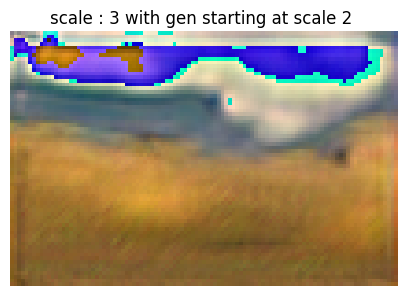

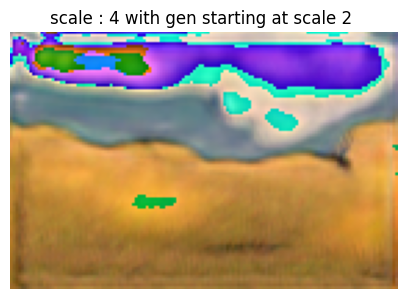

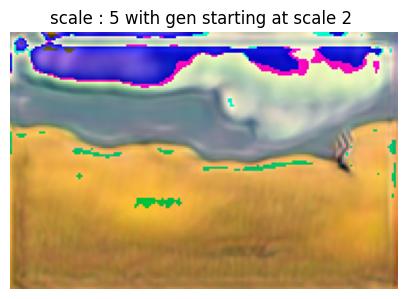

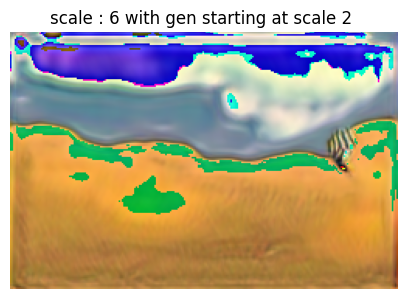

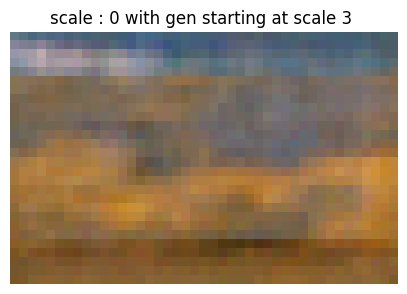

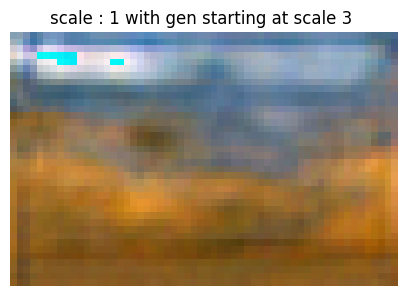

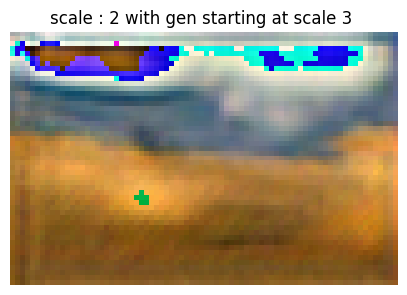

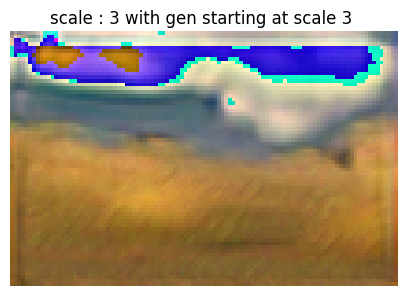

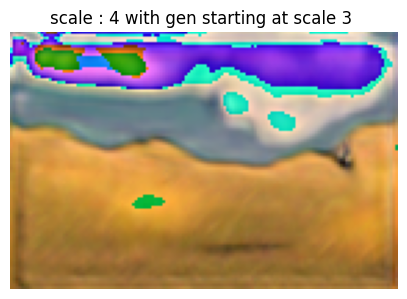

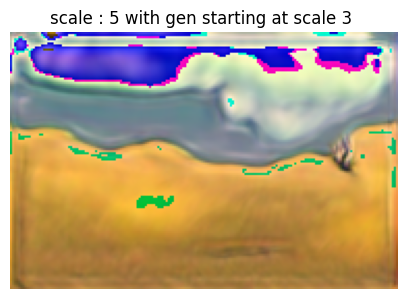

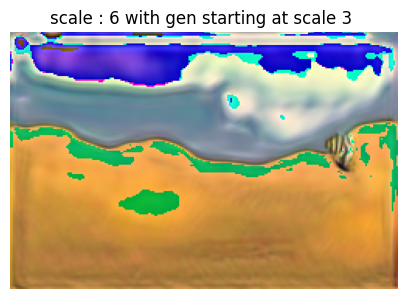

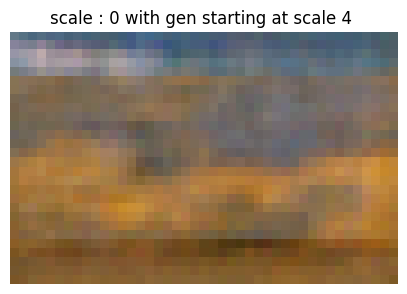

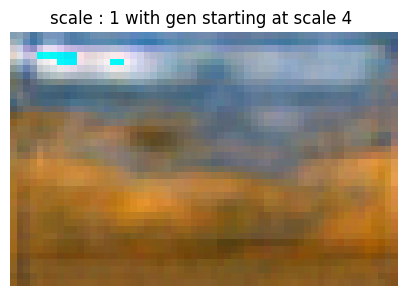

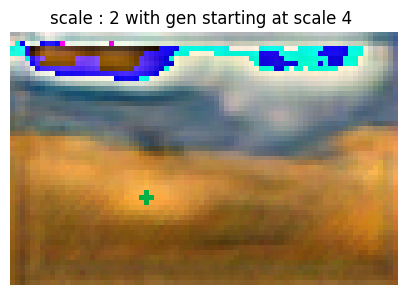

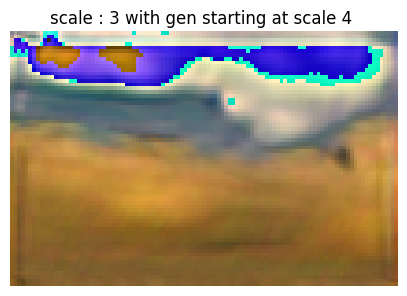

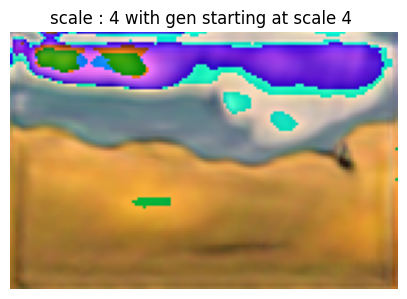

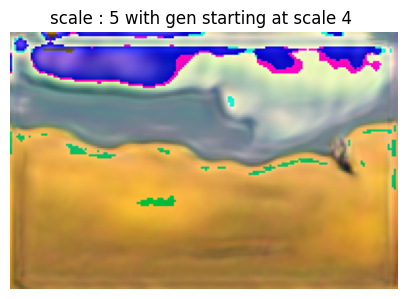

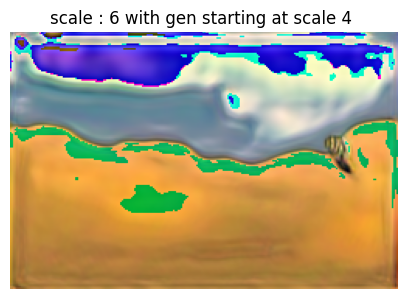

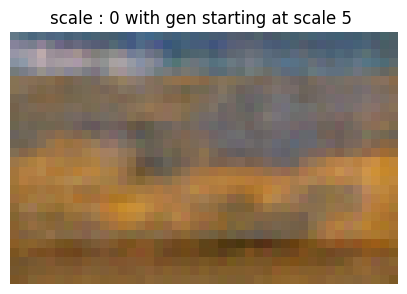

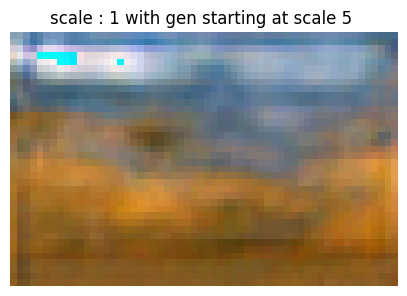

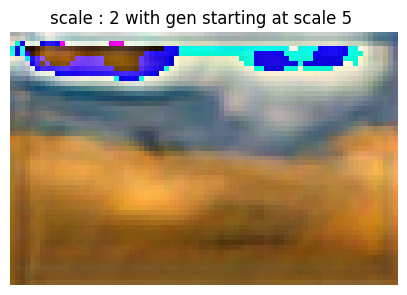

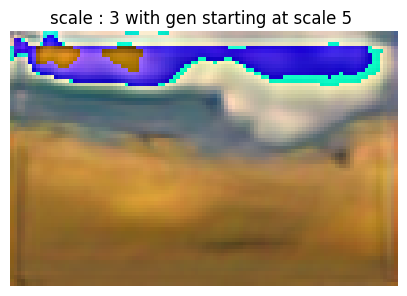

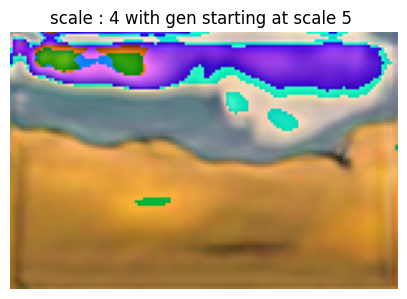

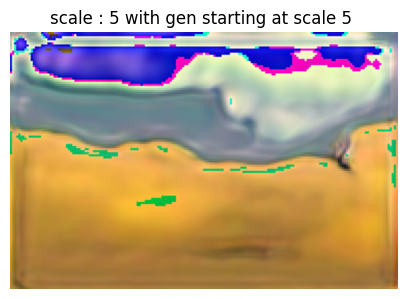

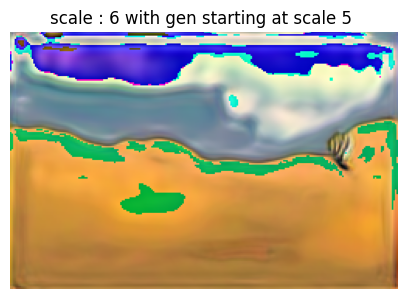

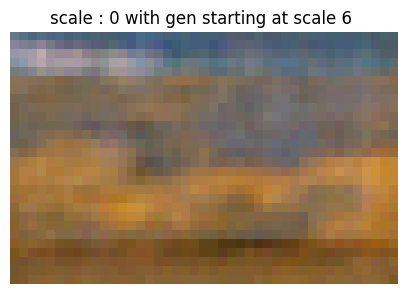

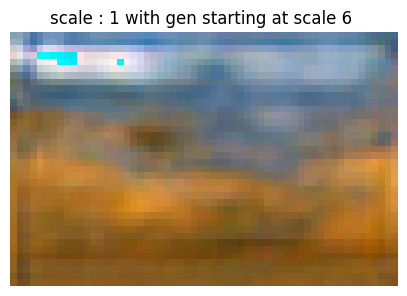

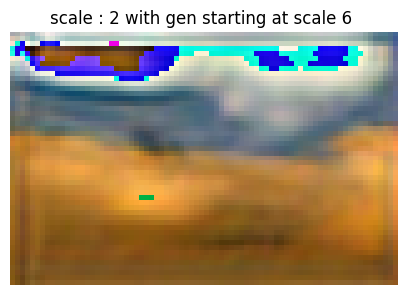

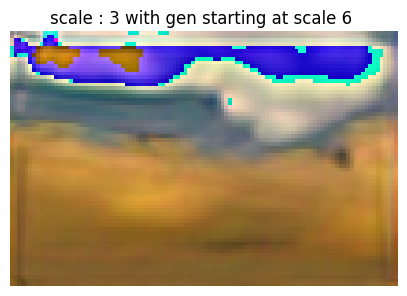

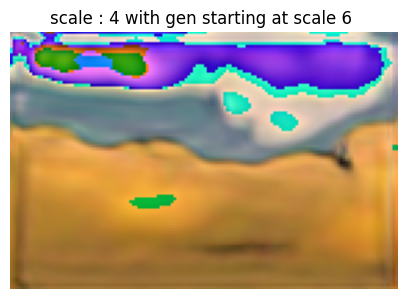

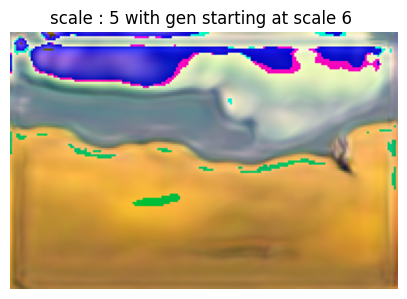

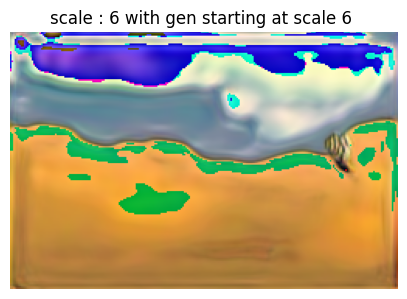

In [53]:

for start_scale in range(N):
    final_gen = generate_multiscale(start_scale=start_scale)
    for i,x in enumerate(final_gen) : 
        final_img = x.cpu().squeeze()
        plt.figure(figsize=(5,5))
        plt.title(f"scale : {i} with gen starting at scale {start_scale} ")
        plt.imshow(to_pil_image(final_img))
        plt.axis('off')
        plt.show()

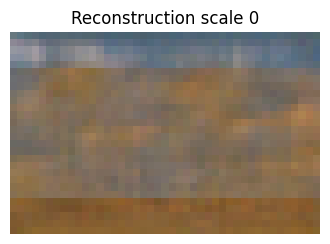

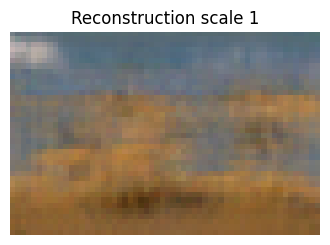

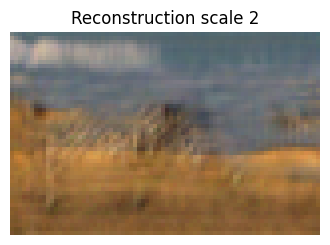

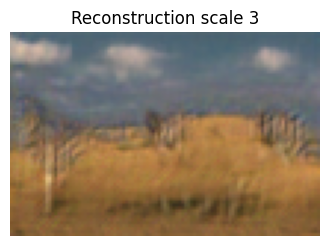

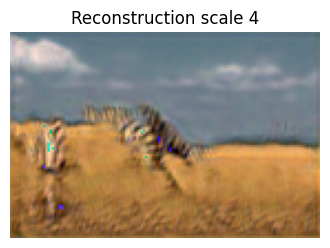

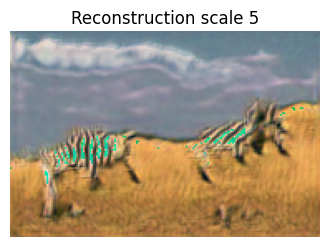

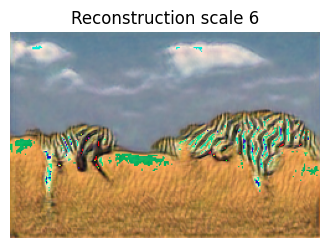

In [51]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_reconstructions(x_rec, scales):
    for i, rec in enumerate(x_rec):
        if rec is None:
            continue
        img = rec.detach().cpu().squeeze()
        plt.figure(figsize=(4,4))
        plt.title(f"Reconstruction scale {i}")
        plt.imshow(to_pil_image(img))
        plt.axis('off')
        plt.show()

plot_reconstructions(gen_image[1:],scales)

In [252]:
torch.random.manual_seed(1)
for x in range(N):  
    print(torch.rand(1),torch.rand(1))

tensor([0.7576]) tensor([0.2793])
tensor([0.4031]) tensor([0.7347])
tensor([0.0293]) tensor([0.7999])
tensor([0.3971]) tensor([0.7544])
tensor([0.5695]) tensor([0.4388])
tensor([0.6387]) tensor([0.5247])
tensor([0.6826]) tensor([0.3051])
